In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import gaussian_kde

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def bootstrap_metrics_ess_matched(
    X, Y, indices_opes, indices_rest2, weights_opes=None,
    n_bootstrap=500, target_points_per_bin=10,
    number_of_bins=None,
    random_seed=100
):
    """
    Compute effective coverage, normalized entropy, and relative coverage
    using bootstrap resampling with ESS-matched samples for OPES and REST2.

    Parameters
    ----------
    X, Y : array-like
        2D coordinates
    indices_opes, indices_rest2 : array-like
        Indices of OPES and REST2 frames
    weights_opes : array-like, optional
        OPES weights. If None, OPES treated as uniform
    n_bootstrap : int
        Number of bootstrap iterations
    target_points_per_bin : int
        Heuristic for choosing 2D histogram resolution if number_of_bins is None
    number_of_bins : int, optional
        If provided, overrides automatic bin selection
    random_seed : int
        RNG seed
    """
    rng = np.random.default_rng(random_seed)

    # ---------- ESS ----------
    if weights_opes is not None:
        ess_opes = (np.sum(weights_opes) ** 2) / np.sum(weights_opes ** 2)
    else:
        ess_opes = len(indices_opes)
    ess_opes = int(np.floor(ess_opes))
    ess_rest2 = ess_opes

    # ---------- BIN SELECTION ----------
    N_total = len(X)
    if number_of_bins is None:
        n_bins = int(np.sqrt(N_total / target_points_per_bin))
    else:
        n_bins = int(number_of_bins)

    xedges = np.linspace(X.min(), X.max(), n_bins+1)
    yedges = np.linspace(Y.min(), Y.max(), n_bins+1)

    # ---------- METRICS ----------
    eff_cov_opes, eff_cov_rest2 = [], []
    norm_ent_opes, norm_ent_rest2 = [], []
    rel_cov_opes, rel_cov_rest2 = [], []

    for _ in range(n_bootstrap):
        # Bootstrap OPES
        if weights_opes is not None:
            probs = weights_opes / np.sum(weights_opes)
            sample_idx_opes = rng.choice(indices_opes, size=ess_opes, replace=True, p=probs)
        else:
            sample_idx_opes = rng.choice(indices_opes, size=ess_opes, replace=True)

        # Bootstrap REST2
        sample_idx_rest2 = rng.choice(indices_rest2, size=ess_rest2, replace=True)

        # 2D histograms
        H_opes = np.histogram2d(X[sample_idx_opes], Y[sample_idx_opes], bins=[xedges, yedges])[0]
        H_rest2 = np.histogram2d(X[sample_idx_rest2], Y[sample_idx_rest2], bins=[xedges, yedges])[0]

        # Metric functions
        def effective_coverage(H):
            w = H.ravel()
            w = w[w>0]
            if w.size==0: return 0.0
            Neff = (w.sum()**2)/np.sum(w**2)
            return Neff / H.size

        def normalized_entropy(H):
            p = H.ravel()
            p = p[p>0]
            p = p/p.sum()
            Hval = -np.sum(p*np.log(p))
            return Hval/np.log(H.size)

        def relative_coverage(HA, HB):
            A_occ = HA>0
            B_occ = HB>0
            if B_occ.sum()==0: return 0.0
            return np.logical_and(A_occ,B_occ).sum()/B_occ.sum()

        eff_cov_opes.append(effective_coverage(H_opes))
        eff_cov_rest2.append(effective_coverage(H_rest2))
        norm_ent_opes.append(normalized_entropy(H_opes))
        norm_ent_rest2.append(normalized_entropy(H_rest2))
        rel_cov_opes.append(relative_coverage(H_opes,H_rest2))
        rel_cov_rest2.append(relative_coverage(H_rest2,H_opes))

    metrics = {
        'n_bins': n_bins,
        'effective_coverage': {
            'OPES': (np.mean(eff_cov_opes), np.std(eff_cov_opes)),
            'REST2': (np.mean(eff_cov_rest2), np.std(eff_cov_rest2))
        },
        'normalized_entropy': {
            'OPES': (np.mean(norm_ent_opes), np.std(norm_ent_opes)),
            'REST2': (np.mean(norm_ent_rest2), np.std(norm_ent_rest2))
        },
        'relative_coverage': {
            'OPES|REST2': (np.mean(rel_cov_opes), np.std(rel_cov_opes)),
            'REST2|OPES': (np.mean(rel_cov_rest2), np.std(rel_cov_rest2))
        }
    }

    return metrics


output_path = './plots_elvim_frag/'
data_path = '../ELVIM_data/fragmentACTR/'


In [3]:
# time cut-off for REST2 to have the same total simulation time (25 us)
time_cutoff = 25000 # ns
nreplicas = 16
dt_per_frame = 0.04 # ns
nframes_rest2 = int(np.round((time_cutoff/nreplicas) / dt_per_frame, decimals=0))
print(nframes_rest2)

# load projection and opes weights
proj = np.loadtxt(data_path+'elvim_run/proj.out')
weights_opes = np.loadtxt(data_path+'weights_opes_300K.txt')
indices_opes = np.arange(weights_opes.shape[0])
indices_rest2 = np.arange(weights_opes.shape[0], proj.shape[0])[:nframes_rest2]
proj = proj[:weights_opes.shape[0]+nframes_rest2]

# CVs
rg_opes = np.loadtxt(data_path+'rg_opes_300K.txt')
alpha_opes = np.loadtxt(data_path+'alpharmsd_opes_300K.txt')
rg_rest2 = np.loadtxt('../REST2/fragment_ACTR/PROD_REST2/dir0/CVS_DATA')[:,1][:nframes_rest2]
alpha_rest2 = np.loadtxt('../REST2/fragment_ACTR/PROD_REST2/dir0/CVS_DATA')[:,2][:nframes_rest2]
rg = np.concatenate((rg_opes, rg_rest2), axis=0)
alpha = np.concatenate((alpha_opes, alpha_rest2), axis=0)


39062


In [4]:

# example run


metrics_boot = bootstrap_metrics_ess_matched(
    X=proj[:,0],
    Y=proj[:,1],
    indices_opes=indices_opes,
    indices_rest2=indices_rest2,
    weights_opes=weights_opes,
    n_bootstrap=500
)

print(f"Histogram bins used: {metrics_boot['n_bins']}")
print("Effective coverage (mean ± std):", metrics_boot['effective_coverage'])
print("Normalized entropy (mean ± std):", metrics_boot['normalized_entropy'])
print("Relative coverage (mean ± std):", metrics_boot['relative_coverage'])


Histogram bins used: 111
Effective coverage (mean ± std): {'OPES': (0.2576715903216432, 0.0025425973549608096), 'REST2': (0.2690307188187527, 0.002392808203520006)}
Normalized entropy (mean ± std): {'OPES': (0.8887334797679722, 0.0005608625805840505), 'REST2': (0.8913764673314408, 0.0005528038226597022)}
Relative coverage (mean ± std): {'OPES|REST2': (0.7764722920356443, 0.003753246219586225), 'REST2|OPES': (0.7938114675213999, 0.0037738812017806397)}


In [5]:


# Compute default number of bins
N_total = len(proj)
target_points_per_bin = 10
default_n_bins = int(np.sqrt(N_total / target_points_per_bin))

# Define bin variations
bin_factors = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
bin_numbers = [max(1, int(default_n_bins * f)) for f in bin_factors]

results = []

for n_bins in bin_numbers:
    metrics_boot = bootstrap_metrics_ess_matched(
        X=proj[:,0],
        Y=proj[:,1],
        indices_opes=indices_opes,
        indices_rest2=indices_rest2,
        weights_opes=weights_opes,
        n_bootstrap=500,
        number_of_bins=n_bins
    )

    # --- Means and stds ---
    eff_opes_mean, eff_opes_std = metrics_boot['effective_coverage']['OPES']
    eff_rest2_mean, eff_rest2_std = metrics_boot['effective_coverage']['REST2']

    ent_opes_mean, ent_opes_std = metrics_boot['normalized_entropy']['OPES']
    ent_rest2_mean, ent_rest2_std = metrics_boot['normalized_entropy']['REST2']

    relcov_opes_mean, relcov_opes_std = metrics_boot['relative_coverage']['OPES|REST2']
    relcov_rest2_mean, relcov_rest2_std = metrics_boot['relative_coverage']['REST2|OPES']

    # --- Normalized differences ---
    def percent_diff_with_error(x_mean, x_std, y_mean, y_std):
        diff = (y_mean - x_mean)
        norm_diff = diff / y_mean
        diff_err = np.sqrt(x_std ** 2 + y_std ** 2)
        norm_diff_err = norm_diff * np.sqrt((diff_err / diff) ** 2 + (y_std / y_mean) ** 2)
        return norm_diff*100, np.abs(norm_diff_err*100)

    eff_diff, eff_diff_err = percent_diff_with_error(eff_opes_mean, eff_opes_std,
                                                        eff_rest2_mean, eff_rest2_std)
    ent_diff, ent_diff_err = percent_diff_with_error(ent_opes_mean, ent_opes_std,
                                                        ent_rest2_mean, ent_rest2_std)
    relcov_diff, relcov_diff_err = percent_diff_with_error(relcov_opes_mean, relcov_opes_std,
                                                              relcov_rest2_mean, relcov_rest2_std)

    results.append({
        'Bins': n_bins,
        'Eff. coverage OPES': f"{eff_opes_mean:.4f} ± {eff_opes_std:.4f}",
        'Eff. coverage REST2': f"{eff_rest2_mean:.4f} ± {eff_rest2_std:.4f}",
        'dEff. coverage (%)': f"{eff_diff:.2f} ± {eff_diff_err:.2f}",
        'Norm. entropy OPES': f"{ent_opes_mean:.4f} ± {ent_opes_std:.4f}",
        'Norm. entropy REST2': f"{ent_rest2_mean:.4f} ± {ent_rest2_std:.4f}",
        'dNorm. entropy (%)': f"{ent_diff:.2f} ± {ent_diff_err:.2f}",
        'Rel. coverage OPES|REST2': f"{relcov_opes_mean:.4f} ± {relcov_opes_std:.4f}",
        'Rel. coverage REST2|OPES': f"{relcov_rest2_mean:.4f} ± {relcov_rest2_std:.4f}",
        'dRel. coverage (%)': f"{relcov_diff:.2f} ± {relcov_diff_err:.2f}",
    })

df_results = pd.DataFrame(results)
df_results.to_csv(output_path+"frag_sampling_metrics_elvim.csv", index=False)
print(df_results)


   Bins Eff. coverage OPES Eff. coverage REST2 dEff. coverage (%)  \
0    27    0.3969 ± 0.0036     0.4008 ± 0.0034        0.98 ± 1.23   
1    55    0.3282 ± 0.0033     0.3335 ± 0.0031        1.60 ± 1.35   
2    83    0.2909 ± 0.0030     0.2983 ± 0.0026        2.48 ± 1.31   
3   111    0.2577 ± 0.0025     0.2690 ± 0.0024        4.22 ± 1.30   
4   138    0.2298 ± 0.0022     0.2411 ± 0.0021        4.66 ± 1.24   
5   166    0.2021 ± 0.0018     0.2134 ± 0.0016        5.29 ± 1.15   
6   194    0.1774 ± 0.0014     0.1892 ± 0.0015        6.27 ± 1.08   

  Norm. entropy OPES Norm. entropy REST2 dNorm. entropy (%)  \
0    0.9026 ± 0.0007     0.9034 ± 0.0007        0.09 ± 0.11   
1    0.9006 ± 0.0006     0.9017 ± 0.0006        0.12 ± 0.10   
2    0.8962 ± 0.0006     0.8976 ± 0.0006        0.15 ± 0.09   
3    0.8887 ± 0.0006     0.8914 ± 0.0006        0.30 ± 0.09   
4    0.8800 ± 0.0005     0.8834 ± 0.0005        0.39 ± 0.08   
5    0.8700 ± 0.0005     0.8742 ± 0.0005        0.48 ± 0.08   
6    0

In [16]:


# Compute default number of bins
N_total = len(proj)
target_points_per_bin = 10
default_n_bins = int(np.sqrt(N_total / target_points_per_bin))

# Define bin variations
bin_factors = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
bin_numbers = [max(1, int(default_n_bins * f)) for f in bin_factors]

results = []

for n_bins in bin_numbers:
    metrics_boot = bootstrap_metrics_ess_matched(
        X=rg,
        Y=alpha,
        indices_opes=indices_opes,
        indices_rest2=indices_rest2,
        weights_opes=weights_opes,
        n_bootstrap=500,
        number_of_bins=n_bins
    )

    # --- Means and stds ---
    eff_opes_mean, eff_opes_std = metrics_boot['effective_coverage']['OPES']
    eff_rest2_mean, eff_rest2_std = metrics_boot['effective_coverage']['REST2']

    ent_opes_mean, ent_opes_std = metrics_boot['normalized_entropy']['OPES']
    ent_rest2_mean, ent_rest2_std = metrics_boot['normalized_entropy']['REST2']

    relcov_opes_mean, relcov_opes_std = metrics_boot['relative_coverage']['OPES|REST2']
    relcov_rest2_mean, relcov_rest2_std = metrics_boot['relative_coverage']['REST2|OPES']

    # --- Normalized differences ---
    def percent_diff_with_error(x_mean, x_std, y_mean, y_std):
        diff = (y_mean - x_mean)
        norm_diff = diff / y_mean
        diff_err = np.sqrt(x_std ** 2 + y_std ** 2)
        norm_diff_err = norm_diff * np.sqrt((diff_err / diff) ** 2 + (y_std / y_mean) ** 2)
        return norm_diff*100, np.abs(norm_diff_err*100)

    eff_diff, eff_diff_err = percent_diff_with_error(eff_opes_mean, eff_opes_std,
                                                        eff_rest2_mean, eff_rest2_std)
    ent_diff, ent_diff_err = percent_diff_with_error(ent_opes_mean, ent_opes_std,
                                                        ent_rest2_mean, ent_rest2_std)
    relcov_diff, relcov_diff_err = percent_diff_with_error(relcov_opes_mean, relcov_opes_std,
                                                              relcov_rest2_mean, relcov_rest2_std)

    results.append({
        'Bins': n_bins,
        'Eff. coverage OPES': f"{eff_opes_mean:.4f} ± {eff_opes_std:.4f}",
        'Eff. coverage REST2': f"{eff_rest2_mean:.4f} ± {eff_rest2_std:.4f}",
        'dEff. coverage (%)': f"{eff_diff:.2f} ± {eff_diff_err:.2f}",
        'Norm. entropy OPES': f"{ent_opes_mean:.4f} ± {ent_opes_std:.4f}",
        'Norm. entropy REST2': f"{ent_rest2_mean:.4f} ± {ent_rest2_std:.4f}",
        'dNorm. entropy (%)': f"{ent_diff:.2f} ± {ent_diff_err:.2f}",
        'Rel. coverage OPES|REST2': f"{relcov_opes_mean:.4f} ± {relcov_opes_std:.4f}",
        'Rel. coverage REST2|OPES': f"{relcov_rest2_mean:.4f} ± {relcov_rest2_std:.4f}",
        'dRel. coverage (%)': f"{relcov_diff:.2f} ± {relcov_diff_err:.2f}",
    })

df_results = pd.DataFrame(results)
df_results.to_csv(output_path+"frag_sampling_metrics_rg_alpha.csv", index=False)
print(df_results)


   Bins Eff. coverage OPES Eff. coverage REST2 dEff. coverage (%)  \
0    27    0.1425 ± 0.0015     0.0997 ± 0.0009      -42.93 ± 1.85   
1    55    0.1295 ± 0.0015     0.0886 ± 0.0010      -46.23 ± 2.08   
2    83    0.1233 ± 0.0015     0.0837 ± 0.0009      -47.44 ± 2.16   
3   111    0.1175 ± 0.0014     0.0814 ± 0.0009      -44.29 ± 2.06   
4   138    0.1114 ± 0.0012     0.0788 ± 0.0009      -41.46 ± 1.96   
5   166    0.1041 ± 0.0011     0.0751 ± 0.0008      -38.57 ± 1.89   
6   194    0.0967 ± 0.0010     0.0701 ± 0.0008      -37.98 ± 1.87   

  Norm. entropy OPES Norm. entropy REST2 dNorm. entropy (%)  \
0    0.7865 ± 0.0010     0.7255 ± 0.0011       -8.41 ± 0.21   
1    0.8155 ± 0.0009     0.7650 ± 0.0009       -6.61 ± 0.16   
2    0.8245 ± 0.0008     0.7800 ± 0.0008       -5.70 ± 0.14   
3    0.8263 ± 0.0007     0.7878 ± 0.0007       -4.88 ± 0.13   
4    0.8250 ± 0.0006     0.7906 ± 0.0007       -4.35 ± 0.12   
5    0.8210 ± 0.0006     0.7913 ± 0.0007       -3.75 ± 0.11   
6    0

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


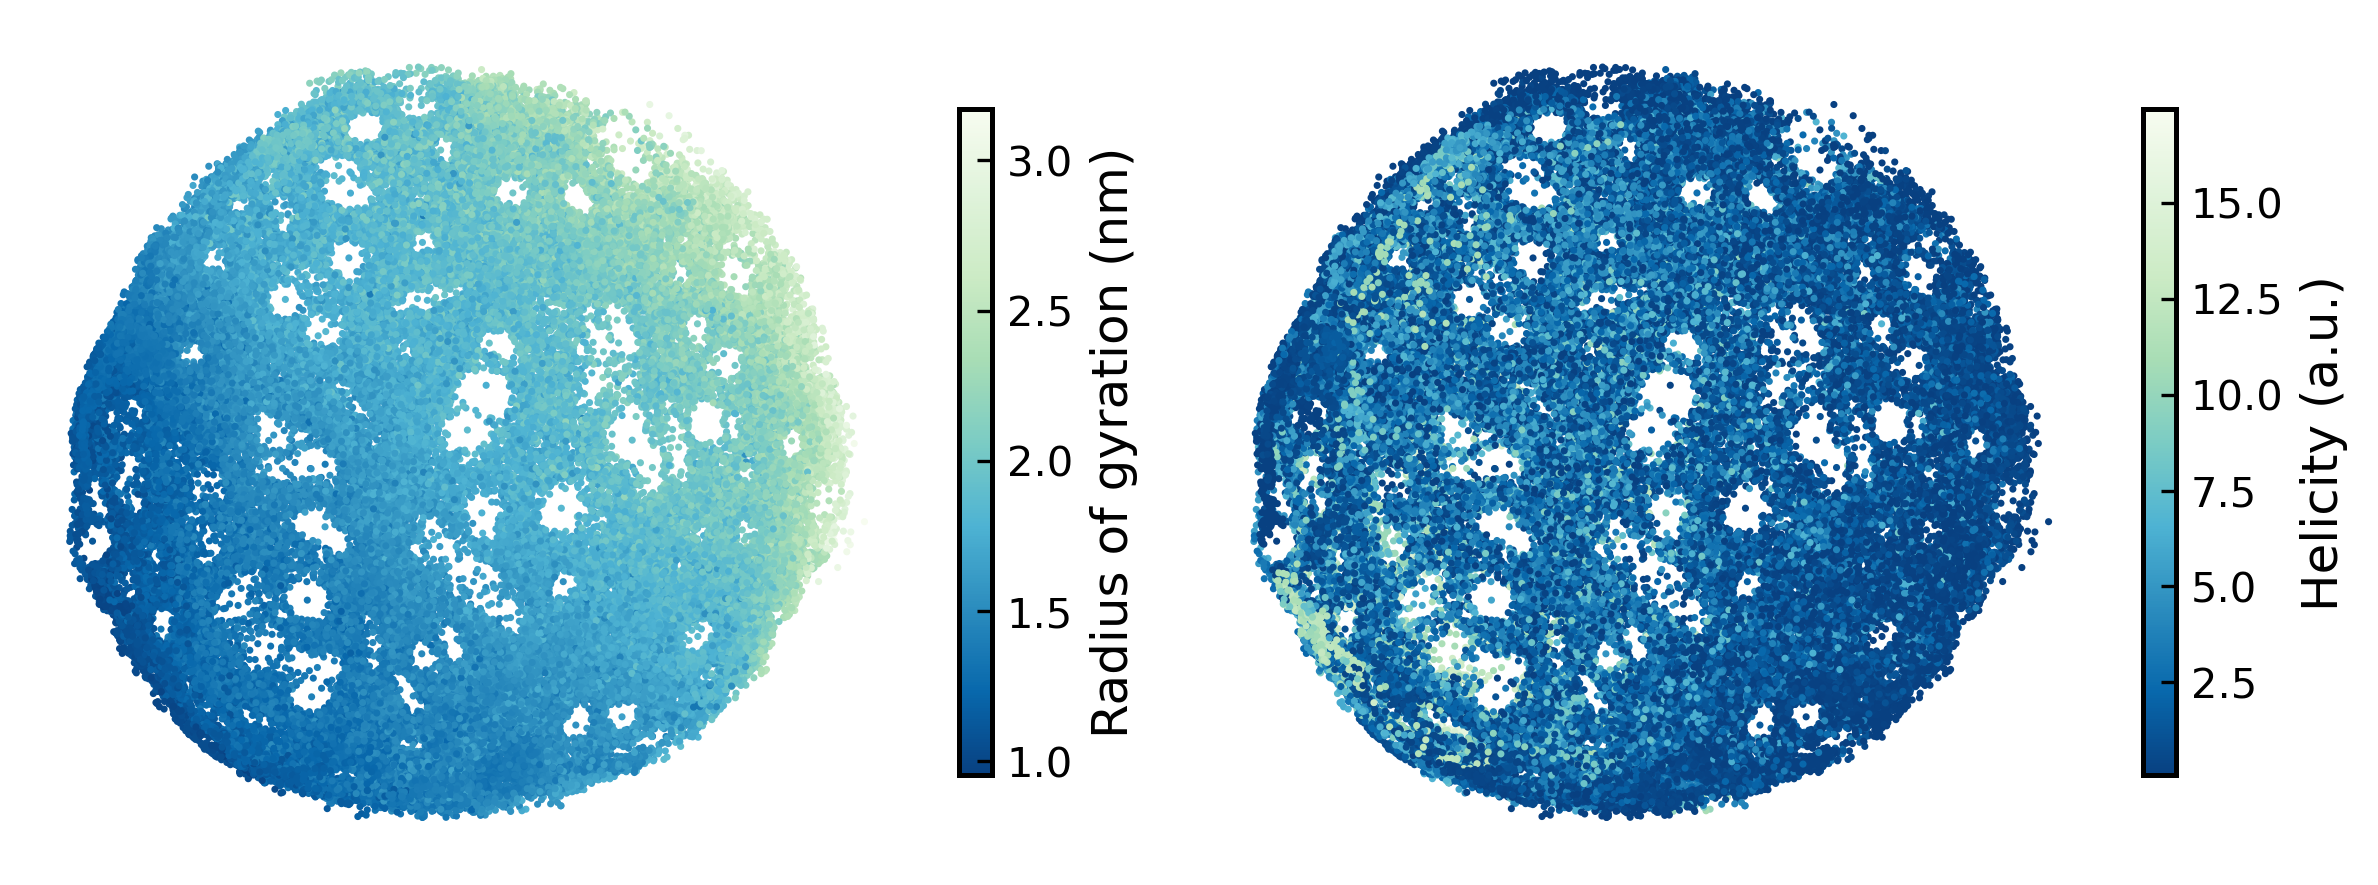

In [10]:
# --- plot full projection ---
plt.figure(figsize=(8, 4))

# Left panel: colored by rg
ax1 = plt.subplot(1, 2, 1)
sc1 = ax1.scatter(proj[:, 0], proj[:, 1], c=rg, s=0.5, cmap='GnBu_r', rasterized=True)
plt.colorbar(sc1, label='Radius of gyration (nm)', shrink = 0.6)

ax1.set_aspect('equal')       # make square
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_frame_on(False)

# Right panel: colored by alpha
ax2 = plt.subplot(1, 2, 2)
sc2 = ax2.scatter(proj[:, 0], proj[:, 1], c=alpha, s=0.5, cmap='GnBu_r', rasterized=True)
plt.colorbar(sc2, label='Helicity (a.u.)', shrink=0.6)

ax2.set_aspect('equal')       # make square
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_frame_on(False)

plt.tight_layout()
plt.savefig(output_path+f"full_proj_rg_alpha.pdf")


/tmp/ipykernel_2485411/3403265907.py:58: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  cmap.set_under('darkblue')   # REST2-only regions
/tmp/ipykernel_2485411/3403265907.py:59: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  cmap.set_over('darkred')    # OPES-only regions


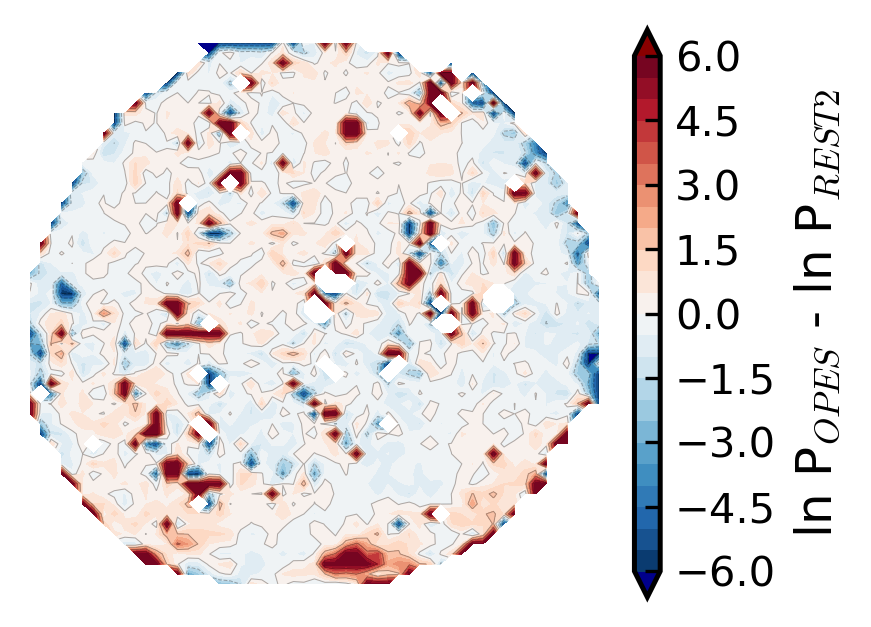

In [11]:
# ============================================================
# Log-probability difference map: OPES vs REST2
# ============================================================
N_total = len(proj)
target_points_per_bin = 10
default_n_bins = int(np.sqrt(N_total / target_points_per_bin))
nbins = int(default_n_bins * 0.5)
max_dlogP = 6.0   # symmetric saturation bound for +/- infinity

# ------------------------------------------------------------
# Build histograms on the SAME grid
# ------------------------------------------------------------
dat1_opes = proj[:, 0][indices_opes]
dat2_opes = proj[:, 1][indices_opes]

dat1_rest = proj[:, 0][indices_rest2]
dat2_rest = proj[:, 1][indices_rest2]

H_opes, xedges, yedges = np.histogram2d(
    dat1_opes,
    dat2_opes,
    bins=nbins,
    weights=weights_opes,
    density=True
)

H_rest, _, _ = np.histogram2d(
    dat1_rest,
    dat2_rest,
    bins=[xedges, yedges],
    density=True
)

xcent = 0.5 * (xedges[:-1] + xedges[1:])
ycent = 0.5 * (yedges[:-1] + yedges[1:])

# ------------------------------------------------------------
# Log-probability difference
# ------------------------------------------------------------
with np.errstate(divide='ignore', invalid='ignore'):
    logP_opes = np.log(H_opes)
    logP_rest = np.log(H_rest)
    dlogP = logP_opes - logP_rest

# Clip infinities for visualization
dlogP = np.clip(dlogP, -max_dlogP, max_dlogP)

dlogP_masked = np.ma.masked_invalid(dlogP.T)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(3., 3.))

levels = np.linspace(-max_dlogP, max_dlogP, 25)

cmap = plt.cm.RdBu_r
cmap.set_under('darkblue')   # REST2-only regions
cmap.set_over('darkred')    # OPES-only regions

cf = plt.contourf(
    xcent,
    ycent,
    dlogP_masked,
    levels=levels,
    cmap=cmap,
    extend='both'
)

for col in cf.collections:
    col.set_rasterized(True)

plt.contour(
    xcent,
    ycent,
    dlogP_masked,
    levels=np.linspace(-max_dlogP, max_dlogP, 9),
    colors='k',
    linewidths=0.25,
    alpha=0.3
)

cbar = plt.colorbar(cf, shrink=0.7)
cbar.set_label("ln P$_{OPES}$ - ln P$_{REST2}$")

plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.gca().set_frame_on(False)

plt.tight_layout()
plt.savefig(output_path + "ELVIM_logPdiff_OPES_vs_REST2.pdf")

